In [1]:
!pip install yfinance plotly scikit-learn tensorflow matplotlib seaborn --quiet

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime

In [3]:
end = datetime.datetime.today()
start = end - datetime.timedelta(days=10*365)

df = yf.download('AAPL', start=start, end=end)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-07-13,28.143677,28.166073,27.843560,28.002577,165762000
2015-07-14,28.132473,28.302688,28.004812,28.228779,127072400
2015-07-15,28.403471,28.477380,28.125753,28.157108,134596800
2015-07-16,28.781977,28.795418,28.522176,28.609523,144889600
2015-07-17,29.030582,29.030582,28.737186,28.909642,184658800


In [4]:
df = df[['Close']]
df.dropna(inplace=True)

In [5]:
print("\nData Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())


Data Summary:
Price         Close
Ticker         AAPL
count   2511.000000
mean     103.640223
std       68.925067
min       20.647453
25%       39.207493
50%       90.251762
75%      163.840698
max      258.396667

Missing Values:
Price  Ticker
Close  AAPL      0
dtype: int64


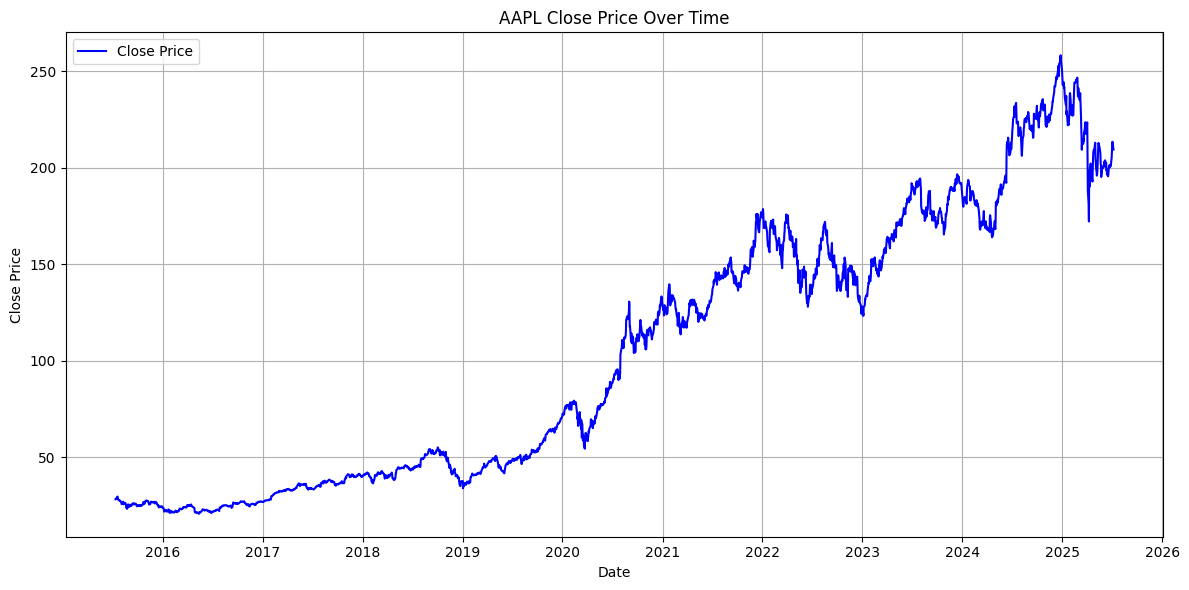

In [6]:
# Plotting the close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('AAPL Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

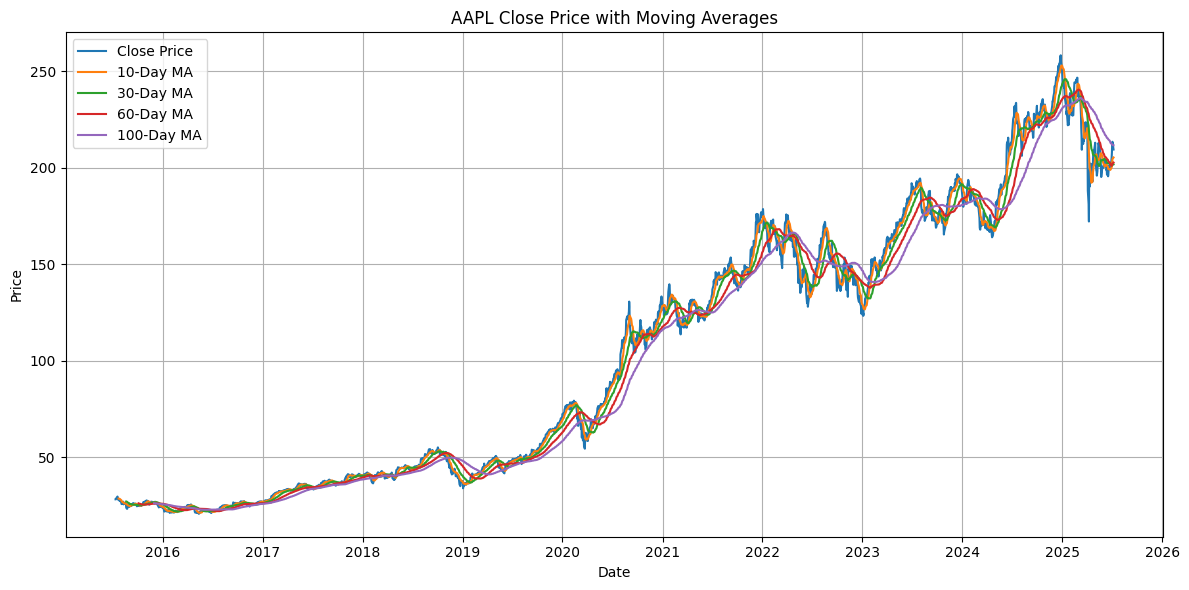

In [7]:
# Moving averages
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA60'] = df['Close'].rolling(window=60).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA10'], label='10-Day MA')
plt.plot(df['MA30'], label='30-Day MA')
plt.plot(df['MA60'], label='60-Day MA')
plt.plot(df['MA100'], label='100-Day MA')
plt.title('AAPL Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df.columns

MultiIndex([('Close', 'AAPL'),
            ( 'MA10',     ''),
            ( 'MA30',     ''),
            ( 'MA60',     ''),
            ('MA100',     '')],
           names=['Price', 'Ticker'])

In [9]:
df.drop(columns=['MA10', 'MA30', 'MA60', 'MA100'], inplace=True)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
scaled_data = scaled_df.values

In [11]:
scaled_data

array([[0.03152996],
       [0.03148284],
       [0.03262268],
       ...,
       [0.80670109],
       [0.81136987],
       [0.7944609 ]])

In [12]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
# 5. Build & Train LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0568 - val_loss: 0.0069
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

In [20]:
# 6. Model Evaluation
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Train RMSE:", np.sqrt(mean_squared_error(y_train_inv, train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_inv, test_pred)))


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train RMSE: 4.18438425209295
Test RMSE: 7.6830721942715865


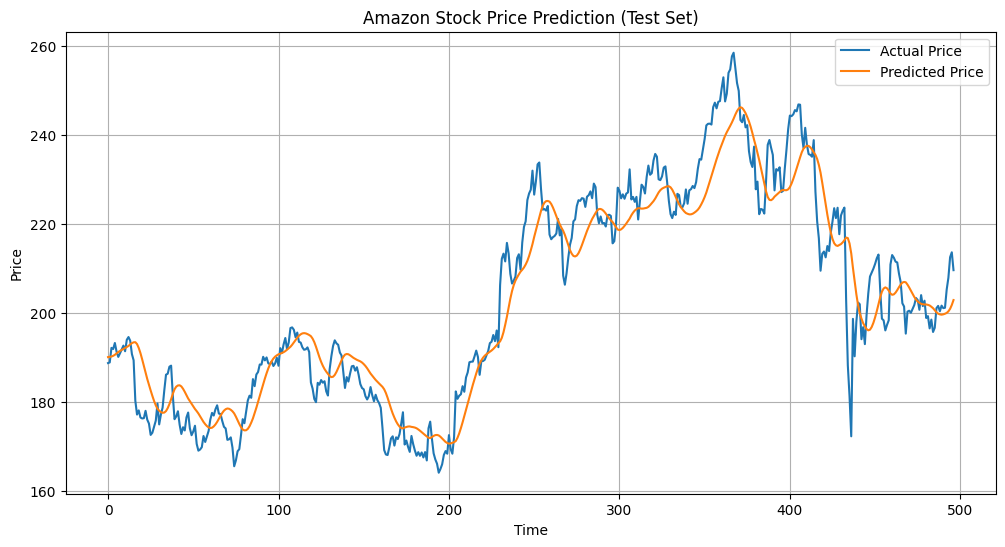

In [21]:
# 7. Plot Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(test_pred, label='Predicted Price')
plt.title('Amazon Stock Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
!pip install keras-tuner --quiet

In [34]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 128, step=32), input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3])),
        loss='mean_squared_error'
    )
    return model

# Reshape input for LSTM
X_train_tuned = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='simple_lstm'
)

tuner.search(X_train_tuned, y_train, epochs=10, validation_split=0.2)

# Train final model with best hyperparameters
best_model = tuner.get_best_models(1)[0]
best_model.fit(X_train_tuned, y_train, epochs=20, validation_split=0.2)


Reloading Tuner from tuner_dir\simple_lstm\tuner0.json
Epoch 1/20


c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017 - val_loss: 3.3130e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2431e-04 - val_loss: 8.9556e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8212e-04 - val_loss: 0.0017
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7101e-04 - val_loss: 7.1195e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8183e-04 - val_loss: 2.3482e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7102e-04 - val_loss: 2.5524e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4160e-04 - val_loss: 3.2275e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1738e-04 - val_loss: 5.7930e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3770e-04 - val_loss: 6.1968e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3858e-04 - val_loss: 2.2525e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2564e-04 - val_loss: 3.773

In [35]:
# 6. Model Evaluation
train_pred_best = best_model.predict(X_train)
test_pred_best = best_model.predict(X_test)

train_pred_best = scaler.inverse_transform(train_pred_best.reshape(-1, 1))
y_train_inv_best = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_best = scaler.inverse_transform(test_pred_best.reshape(-1, 1))
y_test_inv_best = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Train RMSE:", np.sqrt(mean_squared_error(y_train_inv_best, train_pred_best)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_inv_best, test_pred_best)))


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train RMSE: 3.107238898755574
Test RMSE: 4.9258327072869985


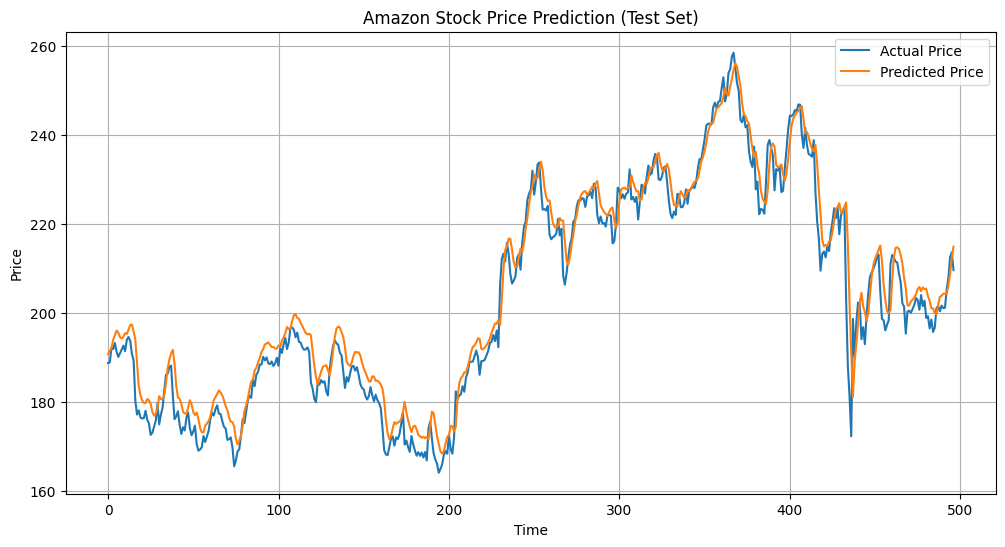

In [36]:
# 7. Plot Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_inv_best, label='Actual Price')
plt.plot(test_pred_best, label='Predicted Price')
plt.title('Amazon Stock Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


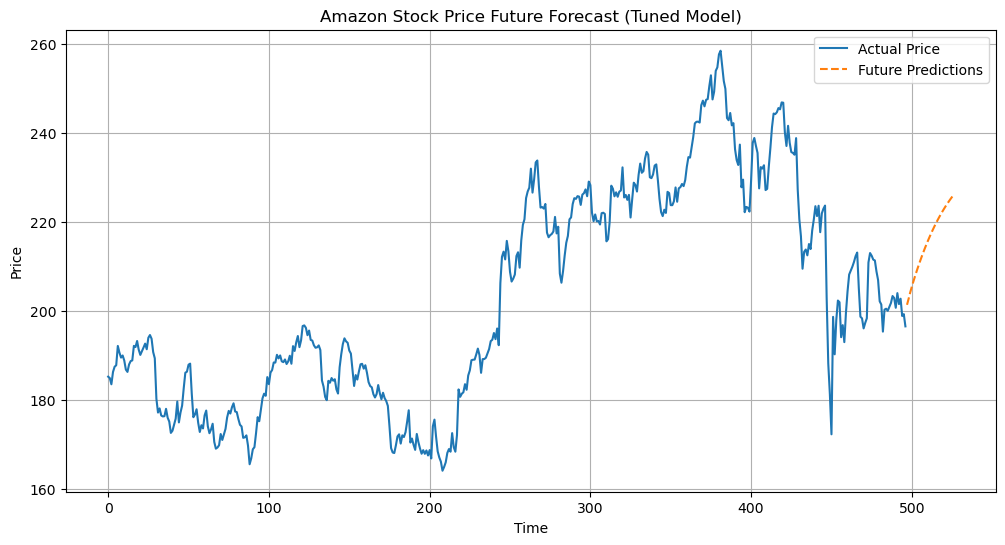

In [26]:
# Forecast future values using the tuned model and plot
import numpy as np

# Define the number of future steps to predict
future_steps = 30

# Prepare the input for prediction
last_sequence = X_test[-1].reshape(1, -1, 1)
future_predictions = []

for _ in range(future_steps):
    next_pred = best_model.predict(last_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_inv_best)), y_test_inv_best, label='Actual Price')
plt.plot(range(len(y_test_inv_best), len(y_test_inv_best) + future_steps), future_predictions_inv, label='Future Predictions', linestyle='--')
plt.title('Amazon Stock Price Future Forecast (Tuned Model)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()